In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from measure_optimize import MeasurementOptimizer, DataProcess 
import matplotlib.pyplot as plt
from itertools import permutations, product
from scipy.sparse import coo_matrix
from pyomo.contrib.pynumero.interfaces.external_grey_box import ExternalGreyBoxModel
from pyomo.contrib.pynumero.interfaces.external_grey_box import ExternalGreyBoxBlock

## Input Setting

### All measurements and index

- ads.gas_inlet.F (0)
- ads.gas_outlet.F (1)
- ads.gas_outlet.T (2)
- ads.gas_outlet.z (3)
- des.gas_inlet.F (4)
- des.gas_outlet.F (5)
- des.gas_outlet.T (6)
- des.gas_outlet.z (7)
- ads.T19 (8)
- ads.T23 (9)
- ads.T28 (10)
- ads.z19 (11)
- ads.z23 (12)
- ads.z28 (13)

One-time cost ones: 0,1,2, 4,5,6, 8,9,10

Time-cost ones: 3,7,11,12,13

In [2]:
all_names = ['Ads.gas_inlet.F', 'Ads.gas_outlet.F', 'Ads.gas_outlet.T', 
             'Ads.gas_outlet.z("CO2")', 'Des.gas_inlet.F', 'Des.gas_outlet.F', 
             'Des.gas_outlet.T', 'Des.gas_outlet.z("CO2")', 'Ads.T_g.Value(19,10)', 
             'Ads.T_g.Value(23,10)', 'Ads.T_g.Value(28,10)', 'Ads.z("CO2",19,10)', 
             'Ads.z("CO2",23,10)', 'Ads.z("CO2",28,10)']

In [3]:
dataObject = DataProcess()

# static measurement jacobian
static_ind = [0,1,2,4,5,6,8,9,10]
static_Nt = 22
static_jaco = dataObject.read_jaco('./RotaryBed/Q'+str(static_Nt)+'_scale.csv')
num_static = len(static_ind)

static_Q = []
for i in static_ind:
    static_Q.append(dataObject.split_jaco(static_jaco, i,static_Nt))

    
    
dynamic_ind = [3,7,11,12,13]
dynamic_Nt = 5
num_dynamic = len(dynamic_ind)
dynamic_jaco = dataObject.read_jaco('./RotaryBed/Q'+str(dynamic_Nt)+'_scale.csv')

dynamic_Q = []
for i in dynamic_ind:
    dynamic_Q.extend(dataObject.split_jaco(dynamic_jaco, i, dynamic_Nt))
    
print("static Q shape:", np.shape(static_Q))
print("dynamic Q shape:", np.shape(dynamic_Q))

jacobian shape: (308, 5)
jacobian shape: (70, 5)
static Q shape: (9, 22, 5)
dynamic Q shape: (25, 5)


In [4]:
static_name = [all_names[i] for i in static_ind]
dynamic_name = [all_names[i] for i in dynamic_ind]

num_param = 5
cost = None

num_total = num_static + num_dynamic*dynamic_Nt

In [5]:
calculator = MeasurementOptimizer(static_Q, dynamic_Q, static_Nt, dynamic_Nt, num_param, cost, verbose=True)

fim_expect = calculator.fim_computation()

print(np.shape(calculator.fim_collection))

(1156, 5, 5)


In [6]:
print(np.shape(calculator.Q[0]))
print(np.shape(np.asarray(calculator.Q[9]).reshape(5,1)))
print(np.shape(calculator.Sigma_inv[(0,9)]))

print(calculator.total_no_measure)

(22, 5)
(5, 1)
(22, 1)
34


### Set up grey-box 

In [7]:
from greybox_generalize import LogDetModel

In [8]:
def build_model_external(m):
    ex_model = LogDetModel(num_para=5)
    m.egb = ExternalGreyBoxBlock()
    m.egb.set_external_model(ex_model)

### Reform the inputs

In [9]:
cost = [1000, #ads.gas_inlet.F (0)
        1000, #ads.gas_outlet.F (1)
         200, #ads.gas_outlet.T (2)
        1000, #des.gas_inlet.F (4)
        1000, #des.gas_outlet.F (5)
         200, #des.gas_outlet.T (6)
         600, #ads.T19 (8)
         600, #ads.T23 (9)
         600 #ads.T28 (10)
       ]

for i in range(dynamic_Nt*num_dynamic):
    cost.append(10)


In [10]:
#print(np.shape(ans_y))

init_y = np.random.rand(num_total)

update_y = [] 

for i in init_y:
    if i > 0.5: 
        update_y.append(1)
    else:
        update_y.append(0)

init_cov_y = [[0]*num_total for i in range(num_total)]

for j in range(num_total):
    for k in range(num_total):
        if j==k:
            init_cov_y[j][k] = update_y[k]
            
        else:
            init_cov_y[j][k] = min(update_y[k], update_y[j])

fim_prior = np.identity((5))
print(fim_prior)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [31]:
def compute_FIM(numRes, FIMSet, cost_list, mixed_integer=False,  obj="A", num_fixed = 9, fix=False, sparse=False, manual_number=20, budget=100):
    
    m = pyo.ConcreteModel()
    
    m.NumRes = pyo.Set(initialize=range(numRes))
    m.DimFIM = pyo.Set(initialize=range(len(FIMSet[0])))
    
    # set up y and cov y 
    def identity(m, a, b):
        return 1 if a==b else 0
    
    def initialize(m, a, b):
        return init_cov_y[a][b]
    
    def DimFIMhalf_init(m):
        return ((a,b) for a in m.NumRes for b in range(a, numRes))
    
    m.NumRes_half = pyo.Set(dimen=2, initialize=DimFIMhalf_init)

    if mixed_integer:
        if sparse:
            m.cov_y = pyo.Var(m.NumRes_half, initialize=initialize, within=pyo.Binary)
        else:
            m.cov_y = pyo.Var(m.NumRes, m.NumRes, initialize=initialize, within=pyo.Binary)
    else:
        if sparse:
            m.cov_y = pyo.Var(m.NumRes_half, initialize=initialize, bounds=(0,1), within=pyo.NonNegativeReals)
        else:
            m.cov_y = pyo.Var(m.NumRes, m.NumRes, initialize=initialize, bounds=(0,1), within=pyo.NonNegativeReals)
    
    if fix:
        m.cov_y.fix()
        
    def init_fim(m, p, q):
        return fim_prior[p,q]   
    
    # set up FIM
    m.TotalFIM = pyo.Var(m.DimFIM, m.DimFIM, initialize=init_fim)

    # compute FIM
    def eval_fim(m, a, b):
        if a >= b: 
            summi = 0 
            for i in range(numRes):
                for j in range(numRes):
                    if i>j:
                        summi += m.cov_y[i,j]*FIMSet[i*numRes+j][a][b]
                    else:
                        summi += m.cov_y[j,i]*FIMSet[i*numRes+j][a][b]
            return m.TotalFIM[a,b] == summi
            #return m.TotalFIM[a,b] == sum(m.cov_y[i,j]*FIMSet[i*numRes+j][a][b] for i in range(numRes) for j in range(numRes))
        else:
            #return m.TotalFIM[a,b] == sum(m.cov_y[i,j]*FIMSet[i*numRes+j][a][b] for i in range(numRes) for j in range(numRes))
            return m.TotalFIM[a,b] == m.TotalFIM[b,a]
        
    
    m.TotalDynamic = pyo.Var(initialize=1)
    
    def total_dynamic(m):
        return m.TotalDynamic==sum(m.cov_y[i,i] for i in range(num_fixed, numRes))
    
    m.manual = pyo.Constraint(rule=total_dynamic)
    #m.manual = pyo.Expression(expr=sum(m.cov_y[i,i] for i in range(num_fixed, numRes)))
            
    # y and conv y constraints
    def y_covy1(m, a, b):
        if a > b:
            return m.cov_y[a, b] <= m.cov_y[a, a]
        else:
            return pyo.Constraint.Skip
        
    def y_covy1_sparse(m, a, b):
        return m.cov_y[a, b] <= m.cov_y[a, a]
        
    def y_covy2(m, a, b):
        if a > b:
            return m.cov_y[a, b] <= m.cov_y[b, b]
        else:
            return pyo.Constraint.Skip
        
    def y_covy2_sparse(m, a, b):
        return m.cov_y[a, b] <= m.cov_y[b, b]
        
    def y_covy3(m, a, b):
        if a>b:
            return m.cov_y[a, b] >= m.cov_y[a, a] + m.cov_y[b, b] - 1
        else:
            return pyo.Constraint.Skip
        
    def y_covy3_sparse(m, a, b):
        return m.cov_y[a, b] >= m.cov_y[a, a] + m.cov_y[b, b] - 1

        
    def y_covy4(m, a, b):
        if a>b:
            return m.cov_y[a, b] == m.cov_y[a, a]*m.cov_y[b,b]
        else:
            return pyo.Constraint.Skip
        
    def symmetry(m,a,b):
        if a<b:
            return m.cov_y[a,b] == m.cov_y[b,a]
        else:
            return pyo.Constraint.Skip
    
    def cost_compute(m):
        return m.cost == sum(m.cov_y[i,i]*cost_list[i] for i in range(numRes))
    
    def cost_limit(m):
        return m.cost <= budget
    
    def total_dynamic_con(m):
        return m.TotalDynamic<=manual_number
    
    # set up Design criterion
    def ComputeTrace(m):
        sum_x = sum(m.TotalFIM[j,j] for j in m.DimFIM)
        return sum_x
    
    
    # add constraints
    m.TotalFIM_con = pyo.Constraint(m.DimFIM, m.DimFIM, rule=eval_fim)

    if mixed_integer and not fix:
        m.sym = pyo.Constraint(m.NumRes, m.NumRes, rule=symmetry)
    
    if not fix:
        if not sparse:
            # if fix, we cannot make sure this is true 
            #m.con_manual = pyo.Constraint(expr= m.manual<= manual_number)
            #if not mixed_integer:
            m.cov1 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy1)
            m.cov2 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy2)
            m.cov3 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy3)
            #else:
            #    m.cov4 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy4)
            
        else: 
            m.cov1_sparse = pyo.Constraint(m.NumRes_half, rule=y_covy1)
            m.cov2_sparse = pyo.Constraint(m.NumRes_half, rule=y_covy2)
            m.cov3_sparse = pyo.Constraint(m.NumRes_half, rule=y_covy3)
            
        m.con_manual = pyo.Constraint(rule=total_dynamic_con)
        m.cost = pyo.Var(initialize=budget)
        m.cost_compute = pyo.Constraint(rule=cost_compute)
        m.budget_limit = pyo.Constraint(rule=cost_limit)
            
     
    # set objective 
    if obj == "A":
        m.Obj = pyo.Objective(rule=ComputeTrace, sense=pyo.maximize)    
    elif obj =="D":
        
        def _model_i(b):
            build_model_external(b)
        m.my_block = pyo.Block(rule=_model_i)

        def eq_fim00(m):
            return m.TotalFIM[0,0] == m.my_block.egb.inputs['ele_0_0']

        def eq_fim11(m):
            return m.TotalFIM[1,1] == m.my_block.egb.inputs['ele_1_1']

        def eq_fim22(m):
            return m.TotalFIM[2,2] == m.my_block.egb.inputs['ele_2_2']

        def eq_fim33(m):
            return m.TotalFIM[3,3] == m.my_block.egb.inputs['ele_3_3']

        def eq_fim44(m):
            return m.TotalFIM[4,4] == m.my_block.egb.inputs['ele_4_4']

        m.eq1 = pyo.Constraint(rule=eq_fim00)
        m.eq2 = pyo.Constraint(rule=eq_fim11)
        m.eq3 = pyo.Constraint(rule=eq_fim22)
        m.eq4 = pyo.Constraint(rule=eq_fim33)
        m.eq5 = pyo.Constraint(rule=eq_fim44)

        def eq_fim01(m):
            return m.TotalFIM[0,1] == m.my_block.egb.inputs['ele_0_1']

        def eq_fim02(m):
            return m.TotalFIM[0,2] == m.my_block.egb.inputs['ele_0_2']

        def eq_fim03(m):
            return m.TotalFIM[0,3] == m.my_block.egb.inputs['ele_0_3']

        def eq_fim04(m):
            return m.TotalFIM[0,4] == m.my_block.egb.inputs['ele_0_4']

        def eq_fim12(m):
            return m.TotalFIM[1,2] == m.my_block.egb.inputs['ele_1_2']

        m.eq6 = pyo.Constraint(rule=eq_fim01)
        m.eq7 = pyo.Constraint(rule=eq_fim02)
        m.eq8 = pyo.Constraint(rule=eq_fim03)
        m.eq9 = pyo.Constraint(rule=eq_fim04)
        m.eq10 = pyo.Constraint(rule=eq_fim12)

        def eq_fim13(m):
            return m.TotalFIM[1,3] == m.my_block.egb.inputs['ele_1_3']

        def eq_fim14(m):
            return m.TotalFIM[1,4] == m.my_block.egb.inputs['ele_1_4']

        def eq_fim23(m):
            return m.TotalFIM[2,3] == m.my_block.egb.inputs['ele_2_3']

        def eq_fim24(m):
            return m.TotalFIM[2, 4] == m.my_block.egb.inputs['ele_2_4']

        def eq_fim34(m):
            return m.TotalFIM[3,4] == m.my_block.egb.inputs['ele_3_4']

        m.eq11 = pyo.Constraint(rule=eq_fim13)
        m.eq12 = pyo.Constraint(rule=eq_fim14)
        m.eq13 = pyo.Constraint(rule=eq_fim23)
        m.eq14 = pyo.Constraint(rule=eq_fim24)
        m.eq15 = pyo.Constraint(rule=eq_fim34)

        # add objective to maximize log det
        m.Obj = pyo.Objective(expr=m.my_block.egb.outputs['log_det'], sense=pyo.maximize)

    
    return m 

In [32]:
mip_option = False
objective = "A"
budget_opt = 5000
sparse_opt = True
fix_opt = False

In [33]:
mod = compute_FIM(num_total, calculator.fim_collection, cost, mixed_integer=mip_option, 
                  obj=objective, fix=fix_opt, sparse=sparse_opt, budget=budget_opt)

if not mip_option and objective=="A":
    solver = pyo.SolverFactory('ipopt')
    solver.options['linear_solver'] = "ma57"
    solver.solve(mod, tee=True)

elif mip_option and objective=="A":
    solver = pyo.SolverFactory('mindtpy')
    results = solver.solve(mod, tee=True, integer_tolerance=0.5)

elif objective=="D":  
    solver = pyo.SolverFactory('cyipopt')
    solver.config.options['hessian_approximation'] = 'limited-memory' 
    additional_options={'max_iter':3000}
    for k,v in additional_options.items():
        solver.config.options[k] = v
    results = solver.solve(mod, tee=True)

ERROR: Rule failed when generating expression for Constraint TotalFIM_con with
    index (0, 0): KeyError: "Index '(1, 0)' is not valid for indexed component
    'cov_y'"
ERROR: Constructing component 'TotalFIM_con' from data=None failed: KeyError:
    "Index '(1, 0)' is not valid for indexed component 'cov_y'"


KeyError: "Index '(1, 0)' is not valid for indexed component 'cov_y'"

In [20]:
### FIM
fim_result = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        fim_result[i,j] = pyo.value(mod.TotalFIM[i,j])
        
print(fim_result)  
print('trace:', np.trace(fim_result))
print('det:', np.linalg.det(fim_result))

print("Pyomo OF:", pyo.value(mod.Obj))
print("Log_det:", np.log(np.linalg.det(fim_result)))

[[ 1.14450354e+03  8.33380009e+00 -8.39597662e+02  2.88813793e+03
  -1.86683139e+02]
 [ 8.33380009e+00  2.84463635e-01 -4.62014729e+00  2.45278989e+01
  -2.10180963e+00]
 [-8.39597662e+02 -4.62014729e+00  6.40240438e+02 -2.15408094e+03
   1.30765538e+02]
 [ 2.88813793e+03  2.45278989e+01 -2.15408094e+03  8.00729173e+03
  -4.42083165e+02]
 [-1.86683139e+02 -2.10180963e+00  1.30765538e+02 -4.42083165e+02
   5.84804520e+01]]
trace: 9850.800621027367
det: 35053359.440061405
Pyomo OF: 9850.800621027367
Log_det: 17.372382013929194


In [ ]:
# problem size calculator
if True:
    nr = num_total
    npa = 5
    num_var = (nr*nr+nr)/2 + npa*npa + 1
    num_equal = npa*npa+1
    num_ineq = 1.5*(nr**2-nr)+1

    print(num_var, num_equal, num_ineq)

In [21]:
import numpy as np

ans_y = np.zeros((num_total,num_total))

pyomo_y = np.zeros((num_total, num_total))

for i in range(num_total):
    for j in range(i, num_total):
        cov = pyo.value(mod.cov_y[i,j])
        ans_y[i,j] = cov 
        ans_y[j,i] = pyo.value(mod.cov_y[j,i])

for i in range(num_total):
    for j in range(num_total):
        pyomo_y[i,j] = pyo.value(mod.cov_y[i,j])
        
print("Cost for this stragy:", pyo.value(mod.cost))
print("Cost if no budget:", sum(cost))

Cost for this stragy: 5000.0
Cost if no budget: 6450


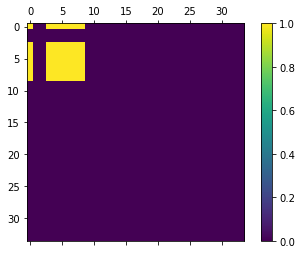

(34, 34)


In [22]:
figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(ans_y, interpolation='nearest')
figure.colorbar(caxes)

plt.show()

print(np.shape(ans_y))

In [23]:
for i in range(len(ans_y)):
    for j in range(len(ans_y[0])):
        if ans_y[i][j] < 0.05:
            ans_y[i][j] = int(0)
        elif ans_y[i][j] > 0.95:
            ans_y[i][j] = int(1)
        else: 
            ans_y[i][j] = round(ans_y[i][j], 2)
print(ans_y)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [25]:
import pickle

store = False

if store:
    file = open('Fe23_D_110_3000', 'wb')

    pickle.dump(ans_y, file)

    file.close()

In [26]:
for c in range(num_static):
    print(static_name[c], ": ", ans_y[c,c])

sol_y = np.asarray([ans_y[i,i] for i in range(num_static, num_total)])

sol_y = np.reshape(sol_y, (num_dynamic, dynamic_Nt))
np.around(sol_y)

for r in range(len(sol_y)):
    print(dynamic_name[r], ": ", sol_y[r])

Ads.gas_inlet.F :  1.0
Ads.gas_outlet.F :  0.0
Ads.gas_outlet.T :  0.0
Des.gas_inlet.F :  1.0
Des.gas_outlet.F :  1.0
Des.gas_outlet.T :  1.0
Ads.T_g.Value(19,10) :  1.0
Ads.T_g.Value(23,10) :  1.0
Ads.T_g.Value(28,10) :  1.0
Ads.gas_outlet.z("CO2") :  [0. 0. 0. 0. 0.]
Des.gas_outlet.z("CO2") :  [0. 0. 0. 0. 0.]
Ads.z("CO2",19,10) :  [0. 0. 0. 0. 0.]
Ads.z("CO2",23,10) :  [0. 0. 0. 0. 0.]
Ads.z("CO2",28,10) :  [0. 0. 0. 0. 0.]


In [ ]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
        
        
    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
#measure_name = ['Ads.gas_inlet.F', 'Ads.gas_outlet.F', 'Ads.gas_outlet.T', 'Ads.gas_outlet.z("CO2")', 'Des.gas_inlet.F', 'Des.gas_outlet.F', 'Des.gas_outlet.T', 'Des.gas_outlet.z("CO2")', 'Ads.T_g.Value(19,10)', 'Ads.T_g.Value(23,10)', 'Ads.T_g.Value(28,10)', 'Ads.z("CO2",19,10)', 'Ads.z("CO2",23,10)', 'Ads.z("CO2",28,10)']
#measure_name = ['Ads.gas_outlet.z("CO2")', 'Des.gas_outlet.z("CO2")', 'Ads.z("CO2",19,10)', 'Ads.z("CO2",23,10)', 'Ads.z("CO2",28,10)']
measure_name = ['a', 'b', 'c', 'd', 'e']

#time_set = ['500', '1000', '1500', '2000', '2200']
time_set = np.linspace(20, 2200, number_t)
time_set = [str(i) for i in time_set]
print(len(time_set), len(measure_name))
print(np.shape(sol_y))

fig, ax = plt.subplots(figsize=(16,8))

im, cbar = heatmap(sol_y, time_set, measure_name, ax=ax,
                   cmap="YlGn", cbarlabel="weight")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [ ]:
def plot_data(budget, a_cri, d_cri):

    si=18
    plt.rc('axes', titlesize=si)
    plt.rc('axes', labelsize=si)
    plt.rc('xtick', labelsize=si)
    plt.rc('ytick', labelsize=si)

    plt.scatter(budget, np.log10(a_cri), s=50, color='red', label='A-optimality')
    #plt.scatter(budget, np.log10(d_cri), marker='v', s=50, color='blue', label='D-optimality')
    plt.xlabel('Budget', fontweight="bold")
    plt.ylabel('log10(A-optimality)', fontweight="bold")
    
    plt.show()
    
    
    si=18
    plt.rc('axes', titlesize=si)
    plt.rc('axes', labelsize=si)
    plt.rc('xtick', labelsize=si)
    plt.rc('ytick', labelsize=si)

    #plt.scatter(budget, np.log10(a_cri), s=50, color='red', label='A-optimality')
    plt.scatter(budget, np.log10(d_cri), marker='v', s=50, color='blue', label='D-optimality')
    plt.xlabel('Budget', fontweight="bold")
    plt.ylabel('log10(D-optimality)', fontweight="bold")
    
    plt.show()

In [ ]:
a_set = [65693.94, 66574.63, 67474.485, 67608.817]
d_set = [np.exp(30.13), np.exp(30.719), np.exp(31.1205), np.exp(31.2586)]

plot_data([3000,4000,5000,6400], a_set, d_set)